In [10]:
from graph_tool.all import Graph, graph_draw, shortest_distance, random_spanning_tree, GraphView
import python_codes.files_operators
import random

def add_random_edges(graph, num_edges, edge_color_map):
    existing_edges = set((int(e.source()), int(e.target())) for e in graph.edges())
    vertices = list(graph.vertices())
    added_edges = 0
    while added_edges < num_edges:
        v1, v2 = random.sample(vertices, 2)
        edge = (min(v1, v2), max(v1, v2))
        if v1 != v2 and edge not in existing_edges:
            e = graph.add_edge(v1, v2)
            edge_color_map[e] = [1, 0, 0, 1]  # Red
            existing_edges.add(edge)
            added_edges += 1

def calculate_total_shortest_path_sum(graph):
    total_sum = 0
    for v in graph.vertices():
        distances = shortest_distance(graph, source=v)
        total_sum += sum(distances.a)
    return total_sum

# Step 1: Read graph and position
filename1 = "Germany50"
read_graph, read_pos = python_codes.files_operators.read_files(f"../networks_clusters/{filename1}.net")

# Step 2: Find Minimum Spanning Tree (MST)
mst = Graph(directed=False)
mst.add_vertex(read_graph.num_vertices())
mst.vertex_properties["number"] = mst.new_vertex_property("int")
mst_pos = mst.new_vertex_property("vector<double>")
edge_color_map = mst.new_edge_property("vector<double>")

mst_edge_map = random_spanning_tree(read_graph)

for v in read_graph.vertices():
    mst.vertex_properties["number"][mst.vertex(v)] = read_graph.vertex_properties["number"][v]
    mst_pos[mst.vertex(v)] = read_pos[v]

for e in read_graph.edges():
    if mst_edge_map[e]:
        edge = mst.add_edge(e.source(), e.target())
        edge_color_map[edge] = [0, 0, 1, 1]  # Blue

graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst.pdf')

# Step 3: Add 20 random edges to MST
add_random_edges(mst, 20, edge_color_map)
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 4: Calculate total shortest path sum
total_shortest_path_sum = calculate_total_shortest_path_sum(mst)
print("Total sum of shortest paths:", total_shortest_path_sum)


In [16]:
from graph_tool.all import Graph, graph_draw, shortest_distance, random_spanning_tree
import python_codes.files_operators
import random
from deap import base, creator, tools, algorithms

def add_random_edges(graph, num_edges, edge_color_map=None):
    existing_edges = set((int(e.source()), int(e.target())) for e in graph.edges())
    vertices = list(graph.vertices())
    added_edges = 0
    while added_edges < num_edges:
        v1, v2 = random.sample(vertices, 2)
        edge = (min(v1, v2), max(v1, v2))
        if v1 != v2 and edge not in existing_edges:
            e = graph.add_edge(v1, v2)
            if edge_color_map:
                edge_color_map[e] = [1, 0, 0, 1]  # Red
            existing_edges.add(edge)
            added_edges += 1

def calculate_total_shortest_path_sum(graph):
    total_sum = 0
    for v in graph.vertices():
        distances = shortest_distance(graph, source=v)
        total_sum += sum(distances.a)
    return total_sum

# Step 1: Read graph and position
filename1 = "Germany50"
read_graph, read_pos = python_codes.files_operators.read_files(f"../networks_clusters/{filename1}.net")

# Step 2: Find Minimum Spanning Tree (MST)
mst = Graph(directed=False)
mst.add_vertex(read_graph.num_vertices())
mst.vertex_properties["number"] = mst.new_vertex_property("int")
mst_pos = mst.new_vertex_property("vector<double>")
edge_color_map = mst.new_edge_property("vector<double>")

mst_edge_map = random_spanning_tree(read_graph)

for v in read_graph.vertices():
    mst.vertex_properties["number"][mst.vertex(v)] = read_graph.vertex_properties["number"][v]
    mst_pos[mst.vertex(v)] = read_pos[v]

for e in read_graph.edges():
    if mst_edge_map[e]:
        edge = mst.add_edge(e.source(), e.target())
        edge_color_map[edge] = [0, 0, 1, 1]  # Blue

graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 3: Add 20 random edges to MST
add_random_edges(mst, 20, edge_color_map)
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 4: Genetic Algorithm setup
if "FitnessMin" in dir(creator):
    del creator.FitnessMin
if "Individual" in dir(creator):
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
edge_list = [(int(e.source()), int(e.target())) for e in mst.edges()]
toolbox.register("attr_edge", random.sample, edge_list, len(edge_list))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_edge)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalGraph(individual):
    graph = Graph(directed=False)
    graph.add_vertex(read_graph.num_vertices())
    for source, target in individual:
        graph.add_edge(source, target)
    add_random_edges(graph, 20)  # Ensure 20 random edges are added
    return calculate_total_shortest_path_sum(graph),

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalGraph)

# Create initial population
population = toolbox.population(n=100)

# Genetic Algorithm parameters
NGEN = 50
CXPB = 0.7
MUTPB = 0.2

# Run the Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    print(f"Generation {gen}: Best fitness = {min([ind.fitness.values[0] for ind in population])}")

# Best individual
best_ind = tools.selBest(population, k=1)[0]
print("Best individual:", best_ind)
print("Best fitness:", best_ind.fitness.values[0])

# Construct the graph from the best individual
optimized_graph = Graph(directed=False)
optimized_graph.add_vertex(read_graph.num_vertices())
optimized_graph.vertex_properties["number"] = optimized_graph.new_vertex_property("int")
for v in read_graph.vertices():
    optimized_graph.vertex_properties["number"][optimized_graph.vertex(v)] = read_graph.vertex_properties["number"][v]
optimized_pos = optimized_graph.new_vertex_property("vector<double>")
for v in read_graph.vertices():
    optimized_pos[optimized_graph.vertex(v)] = read_pos[v]
edge_color_map_optimized = optimized_graph.new_edge_property("vector<double>")
for source, target in best_ind:
    e = optimized_graph.add_edge(source, target)
    edge_color_map_optimized[e] = [1, 0, 0, 1]  # Red for optimized edges

# Draw the optimized graph
graph_draw(optimized_graph, optimized_pos, vertex_text=optimized_graph.vertex_properties["number"], edge_color=edge_color_map_optimized, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_optimized.pdf')

# Step 5: Calculate total shortest path sum for the optimized graph
total_shortest_path_sum_optimized = calculate_total_shortest_path_sum(optimized_graph)
print("Total sum of shortest paths for the optimized graph:", total_shortest_path_sum_optimized)


In [19]:
from graph_tool.all import Graph, graph_draw, shortest_distance, random_spanning_tree
import python_codes.files_operators
import random
from deap import base, creator, tools, algorithms

def add_random_edges(graph, num_edges, edge_color_map=None, seed=None):
    if seed is not None:
        random.seed(seed)
    existing_edges = set((int(e.source()), int(e.target())) for e in graph.edges())
    vertices = list(graph.vertices())
    added_edges = 0
    while added_edges < num_edges:
        v1, v2 = random.sample(vertices, 2)
        edge = (min(v1, v2), max(v1, v2))
        if v1 != v2 and edge not in existing_edges:
            e = graph.add_edge(v1, v2)
            if edge_color_map:
                edge_color_map[e] = [1, 0, 0, 1]  # Red
            existing_edges.add(edge)
            added_edges += 1

def calculate_total_shortest_path_sum(graph):
    total_sum = 0
    for v in graph.vertices():
        distances = shortest_distance(graph, source=v)
        total_sum += sum(distances.a)
    return total_sum

# Step 1: Read graph and position
filename1 = "Germany50"
read_graph, read_pos = python_codes.files_operators.read_files(f"../networks_clusters/{filename1}.net")

# Step 2: Find Minimum Spanning Tree (MST)
mst = Graph(directed=False)
mst.add_vertex(read_graph.num_vertices())
mst.vertex_properties["number"] = mst.new_vertex_property("int")
mst_pos = mst.new_vertex_property("vector<double>")
edge_color_map = mst.new_edge_property("vector<double>")

mst_edge_map = random_spanning_tree(read_graph)

for v in read_graph.vertices():
    mst.vertex_properties["number"][mst.vertex(v)] = read_graph.vertex_properties["number"][v]
    mst_pos[mst.vertex(v)] = read_pos[v]

for e in read_graph.edges():
    if mst_edge_map[e]:
        edge = mst.add_edge(e.source(), e.target())
        edge_color_map[edge] = [0, 0, 1, 1]  # Blue

graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 3: Add 20 random edges to MST
add_random_edges(mst, 20, edge_color_map)
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 4: Genetic Algorithm setup
if "FitnessMin" in dir(creator):
    del creator.FitnessMin
if "Individual" in dir(creator):
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
edge_list = [(int(e.source()), int(e.target())) for e in mst.edges()]
toolbox.register("attr_edge", random.sample, edge_list, len(edge_list))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_edge)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalGraph(individual):
    graph = Graph(directed=False)
    graph.add_vertex(read_graph.num_vertices())
    for source, target in individual:
        graph.add_edge(source, target)
    add_random_edges(graph, 20)  # Ensure 20 random edges are added
    return calculate_total_shortest_path_sum(graph),

def cxRandomEdge(ind1, ind2):
    size = min(len(ind1), len(ind2))
    for i in range(size):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

def mutRandomEdge(individual, indpb):
    if random.random() < indpb:
        edge = random.choice(edge_list)
        if edge not in individual:
            individual[random.randint(0, len(individual) - 1)] = edge
    return individual,

toolbox.register("mate", cxRandomEdge)
toolbox.register("mutate", mutRandomEdge, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalGraph)

# Create initial population
population = toolbox.population(n=100)

# Genetic Algorithm parameters
NGEN = 50
CXPB = 0.7
MUTPB = 0.2

# Global best individual
best_ind = None
best_fitness = float('inf')

# Run the Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
        if fit[0] < best_fitness:
            best_fitness = fit[0]
            best_ind = ind
    population = toolbox.select(offspring, k=len(population))
    print(f"Generation {gen}: Best fitness = {best_fitness}")

print("Best individual:", best_ind)
print("Best fitness:", best_fitness)

# Construct the graph from the best individual
optimized_graph = Graph(directed=False)
optimized_graph.add_vertex(read_graph.num_vertices())
optimized_graph.vertex_properties["number"] = optimized_graph.new_vertex_property("int")
for v in read_graph.vertices():
    optimized_graph.vertex_properties["number"][optimized_graph.vertex(v)] = read_graph.vertex_properties["number"][v]
optimized_pos = optimized_graph.new_vertex_property("vector<double>")
for v in read_graph.vertices():
    optimized_pos[optimized_graph.vertex(v)] = read_pos[v]
edge_color_map_optimized = optimized_graph.new_edge_property("vector<double>")
for source, target in best_ind:
    e = optimized_graph.add_edge(source, target)
    edge_color_map_optimized[e] = [1, 0, 0, 1]  # Red for optimized edges

# Draw the optimized graph
graph_draw(optimized_graph, optimized_pos, vertex_text=optimized_graph.vertex_properties["number"], edge_color=edge_color_map_optimized, output_size=(1000, 1000))
graph_draw(optimized_graph, optimized_pos, vertex_text=optimized_graph.vertex_properties["number"], edge_color=edge_color_map_optimized, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_optimized.pdf')
# Step 5: Calculate total shortest path sum for the optimized graph
total_shortest_path_sum_optimized = calculate_total_shortest_path_sum(optimized_graph)
print("Total sum of shortest paths for the optimized graph:", total_shortest_path_sum_optimized)


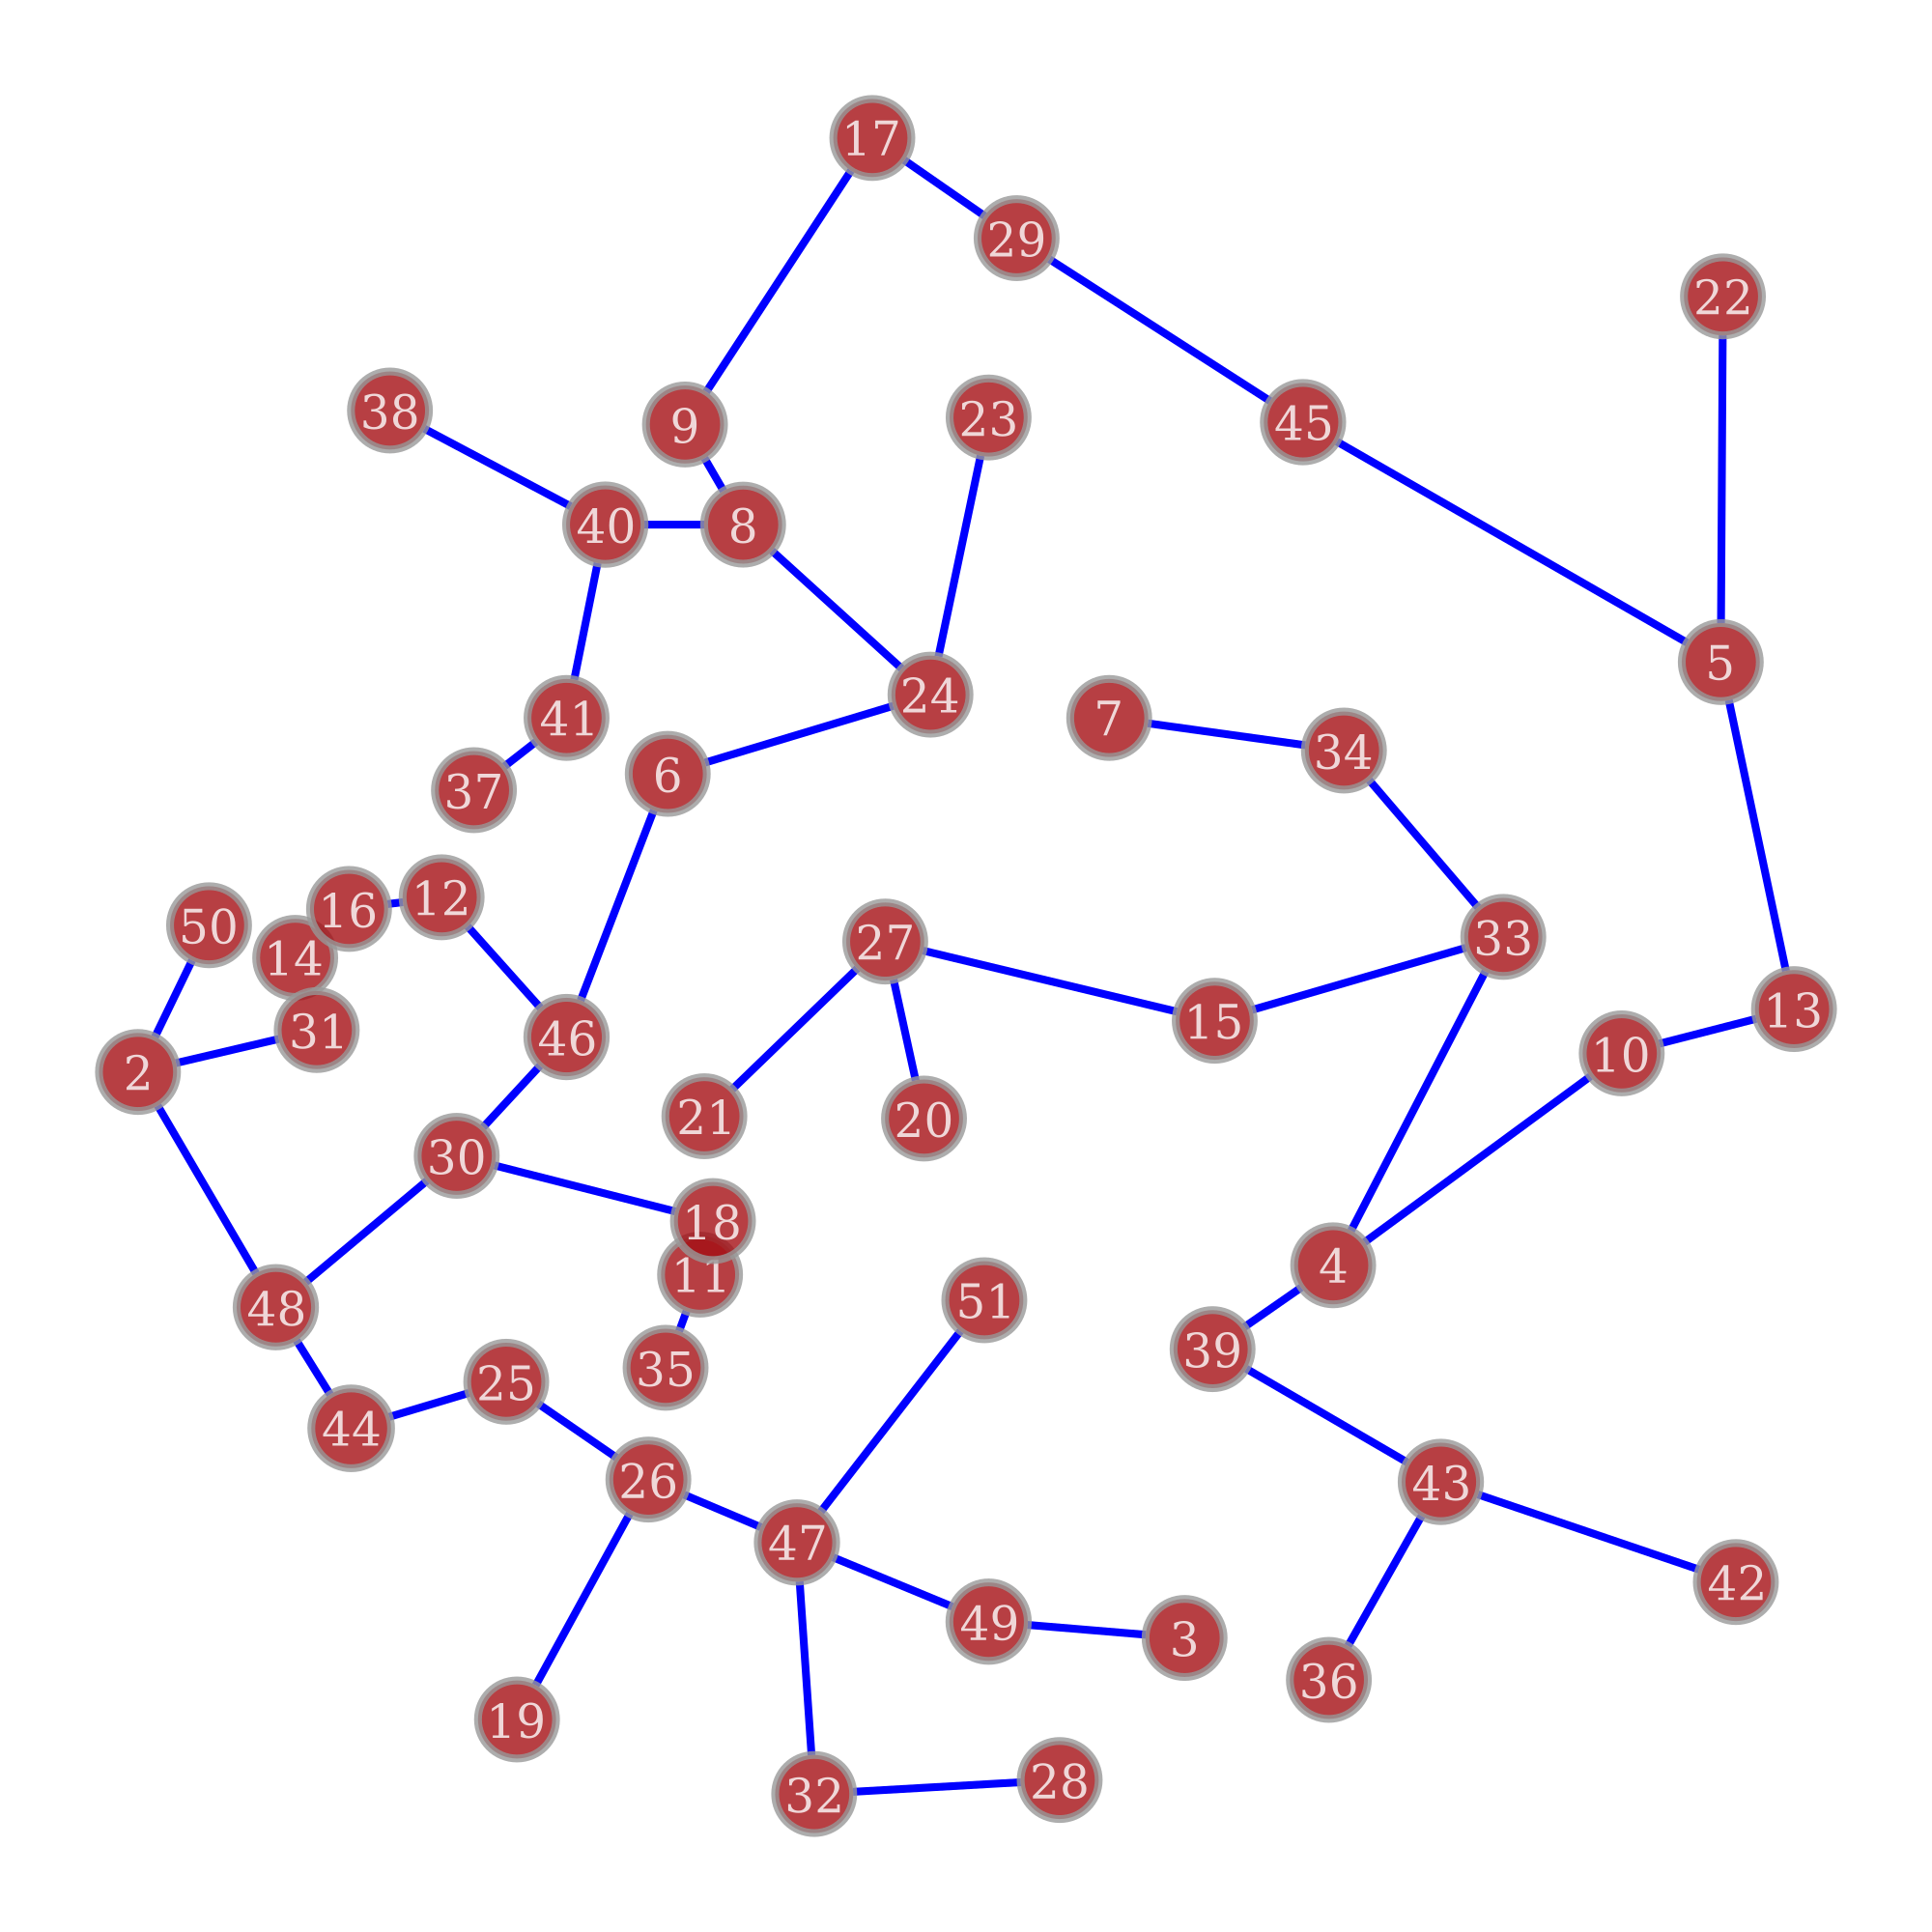

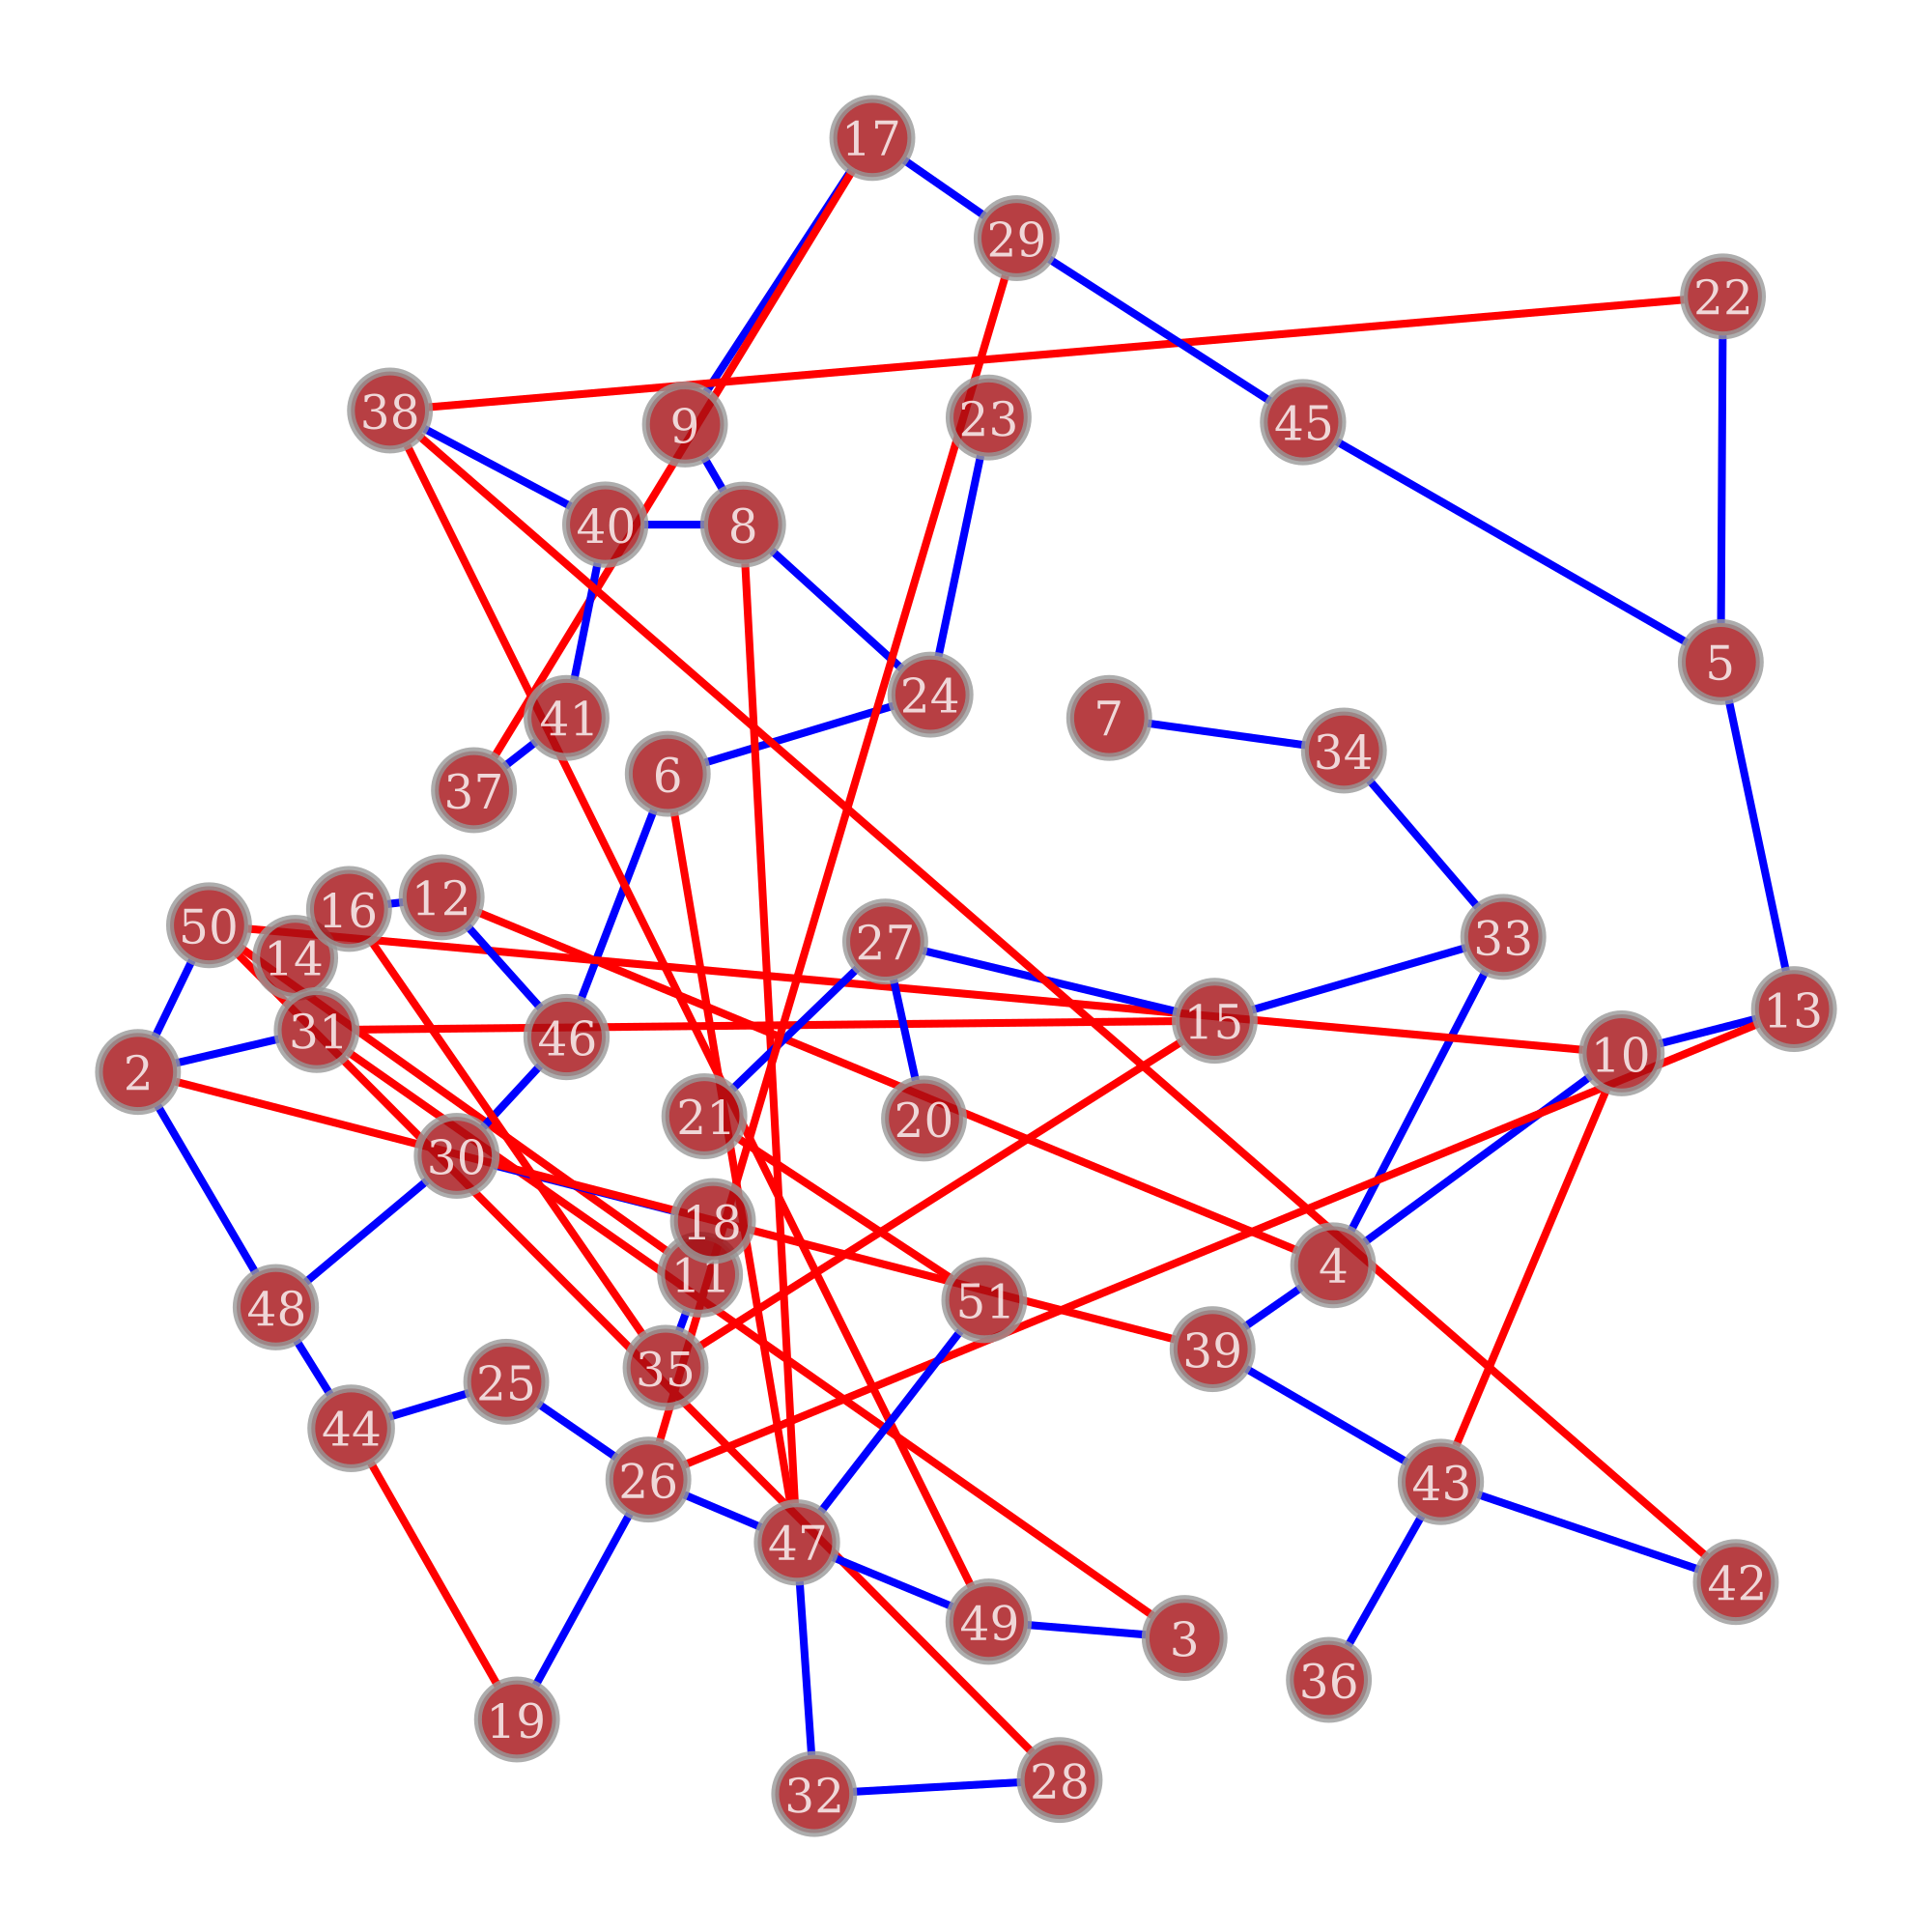

Generation 0: Best fitness = 7446
Generation 1: Best fitness = 7446
Generation 2: Best fitness = 7446
Generation 3: Best fitness = 7446
Generation 4: Best fitness = 7446
Generation 5: Best fitness = 7446
Generation 6: Best fitness = 7446
Generation 7: Best fitness = 7446
Generation 8: Best fitness = 7446
Generation 9: Best fitness = 7446
Generation 10: Best fitness = 7446
Generation 11: Best fitness = 7440
Generation 12: Best fitness = 7440
Generation 13: Best fitness = 7440
Generation 14: Best fitness = 7440
Generation 15: Best fitness = 7412
Generation 16: Best fitness = 7412
Generation 17: Best fitness = 7412
Generation 18: Best fitness = 7412
Generation 19: Best fitness = 7412
Generation 20: Best fitness = 7412
Generation 21: Best fitness = 7412
Generation 22: Best fitness = 7412
Generation 23: Best fitness = 7412
Generation 24: Best fitness = 7412
Generation 25: Best fitness = 7412
Generation 26: Best fitness = 7404
Generation 27: Best fitness = 7404
Generation 28: Best fitness = 

In [14]:
from graph_tool.all import Graph, graph_draw, shortest_distance, random_spanning_tree
import python_codes.files_operators
import random
from deap import base, creator, tools, algorithms

def add_random_edges(graph, num_edges, edge_color_map=None, seed=None):
    if seed is not None:
        random.seed(seed)
    existing_edges = set((int(e.source()), int(e.target())) for e in graph.edges())
    vertices = list(graph.vertices())
    added_edges = 0
    while added_edges < num_edges:
        v1, v2 = random.sample(vertices, 2)
        edge = (min(v1, v2), max(v1, v2))
        if v1 != v2 and edge not in existing_edges:
            e = graph.add_edge(v1, v2)
            if edge_color_map:
                edge_color_map[e] = [1, 0, 0, 1]  # Red
            existing_edges.add(edge)
            added_edges += 1

def calculate_total_shortest_path_sum(graph):
    total_sum = 0
    for v in graph.vertices():
        distances = shortest_distance(graph, source=v)
        total_sum += sum(distances.a)
    return total_sum

# Step 1: Read graph and position
filename1 = "Germany50"
read_graph, read_pos = python_codes.files_operators.read_files(f"../networks_clusters/{filename1}.net")

# Step 2: Find Minimum Spanning Tree (MST)
mst = Graph(directed=False)
mst.add_vertex(read_graph.num_vertices())
mst.vertex_properties["number"] = mst.new_vertex_property("int")
mst_pos = mst.new_vertex_property("vector<double>")
edge_color_map = mst.new_edge_property("vector<double>")

mst_edge_map = random_spanning_tree(read_graph)

for v in read_graph.vertices():
    mst.vertex_properties["number"][mst.vertex(v)] = read_graph.vertex_properties["number"][v]
    mst_pos[mst.vertex(v)] = read_pos[v]

for e in read_graph.edges():
    if mst_edge_map[e]:
        edge = mst.add_edge(e.source(), e.target())
        edge_color_map[edge] = [0, 0, 1, 1]  # Blue

graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 3: Add 20 random edges to MST
add_random_edges(mst, 20, edge_color_map)
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000))
graph_draw(mst, read_pos, vertex_text=mst.vertex_properties["number"], edge_color=edge_color_map, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_mst_with_random_edges.pdf')

# Step 4: Genetic Algorithm setup
if "FitnessMin" in dir(creator):
    del creator.FitnessMin
if "Individual" in dir(creator):
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
edge_list = [(int(e.source()), int(e.target())) for e in mst.edges()]
toolbox.register("attr_edge", random.sample, edge_list, len(edge_list))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_edge)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalGraph(individual):
    graph = Graph(directed=False)
    graph.add_vertex(read_graph.num_vertices())
    for source, target in individual:
        graph.add_edge(source, target)
    add_random_edges(graph, 20)  # Ensure 20 random edges are added
    return calculate_total_shortest_path_sum(graph),

def cxRandomEdge(ind1, ind2):
    size = min(len(ind1), len(ind2))
    for i in range(size):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

def mutRandomEdge(individual, indpb):
    if random.random() < indpb:
        edge = random.choice(edge_list)
        if edge not in individual:
            individual[random.randint(0, len(individual) - 1)] = edge
    return individual,

toolbox.register("mate", cxRandomEdge)
toolbox.register("mutate", mutRandomEdge, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalGraph)

# Create initial population
population = toolbox.population(n=100)

# Genetic Algorithm parameters
NGEN = 50
CXPB = 0.7
MUTPB = 0.2

# Global best individual
best_ind = None
best_fitness = float('inf')

# Run the Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
        if fit[0] < best_fitness:
            best_fitness = fit[0]
            best_ind = ind
    population = toolbox.select(offspring, k=len(population))
    print(f"Generation {gen}: Best fitness = {best_fitness}")

print("Best individual:", best_ind)
print("Best fitness:", best_fitness)

# Construct the graph from the best individual
optimized_graph = Graph(directed=False)
optimized_graph.add_vertex(read_graph.num_vertices())
optimized_graph.vertex_properties["number"] = optimized_graph.new_vertex_property("int")
for v in read_graph.vertices():
    optimized_graph.vertex_properties["number"][optimized_graph.vertex(v)] = read_graph.vertex_properties["number"][v]
optimized_pos = optimized_graph.new_vertex_property("vector<double>")
for v in read_graph.vertices():
    optimized_pos[optimized_graph.vertex(v)] = read_pos[v]
edge_color_map_optimized = optimized_graph.new_edge_property("vector<double>")
for source, target in best_ind:
    e = optimized_graph.add_edge(source, target)
    edge_color_map_optimized[e] = [1, 0, 0, 1]  # Red for optimized edges

# Draw the optimized graph
graph_draw(optimized_graph, optimized_pos, vertex_text=optimized_graph.vertex_properties["number"], edge_color=edge_color_map_optimized, output_size=(1000, 1000), output=f'./output_GA_deap/{filename1}_optimized.pdf')

# Step 5: Recalculate the total shortest path sum for the optimized graph
total_shortest_path_sum_optimized = evalGraph(best_ind)[0]
print("Total sum of shortest paths for the optimized graph:", total_shortest_path_sum_optimized)


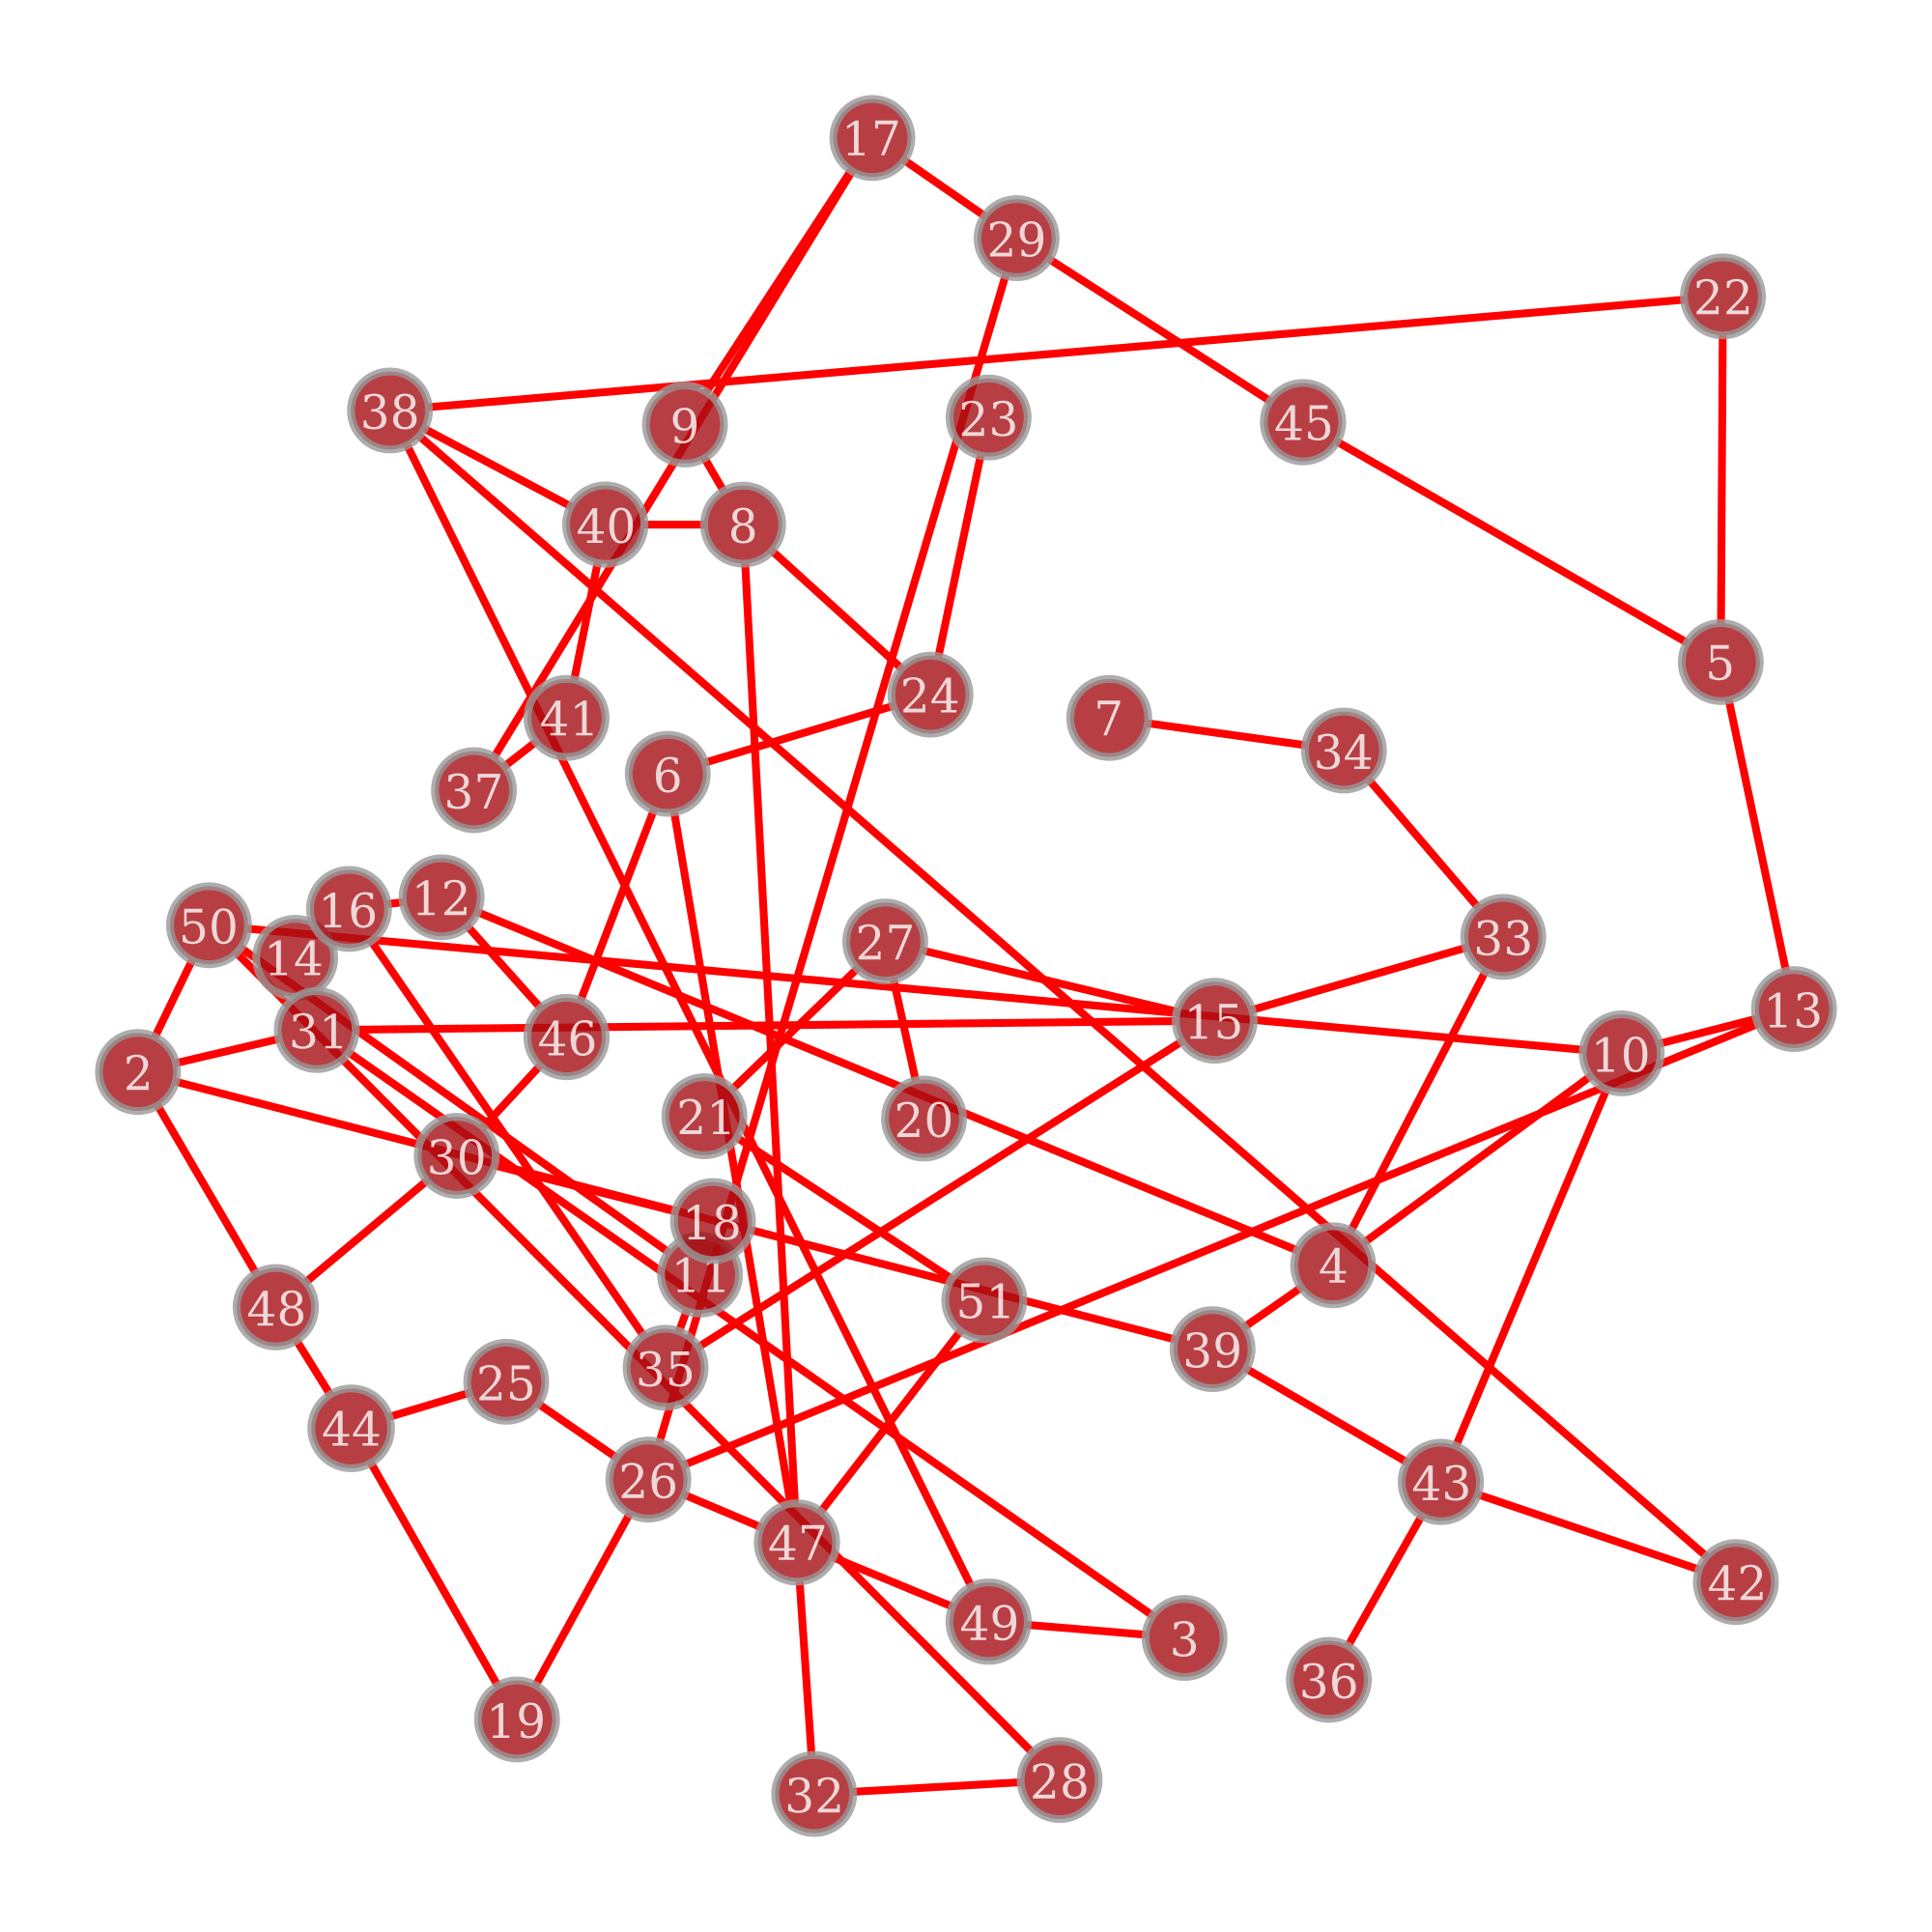

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf3e895880, at 0x7fbf23fe3ad0>

In [15]:
graph_draw(optimized_graph, optimized_pos, vertex_text=optimized_graph.vertex_properties["number"], edge_color=edge_color_map_optimized, output_size=(1000, 1000))